# Explaining models decisions using SHAP - Hear Attack Prediction

## Report


### 1. Prediction calculation and 2. LIME decomposition
A model (Random Forest) was first evaluated on some random observations. The predicted probabilities of the patient being healthy were:
0.99,
0.19,
0.86,
0.92,

![alt text](images/1.png "cp_3 contributes negatively (dalex)")
![alt text](images/2.png "cp_3 contributes positively (dalex)")
![alt text](images/3.png "cp_3 contributes in different ways (shap)")
![alt text](images/4.png "cp_3 contributes in different ways (shap)")

### 5. A variable can contribute positively or negatively
Next I found a feature in the model which can contribute both positively or negatively to the prediction depending on the sample. It is `cp_3`. The same result can be seen no matter which library is used.

![alt text](images/4.png "cp_3 contributes negatively (dalex)")
![alt text](images/5.png "cp_3 contributes positively (dalex)")
![alt text](images/6.png "cp_3 contributes in different ways (shap)")

### 6. `shap` and `dalex` comparison
Both libraries give similar results, however there are some minor discrepancies in the attribution scores. Because `shap` is optimized for use with tree-based models, it is much faster than `dalex` in the setting used in my experiments (random forest).

### 7. Training a different model
I also trained another model (linear regression) on the same task. Its explanation is different from the explanation of the random forest. For example `cp_3` is not important when explaining the random forest, but it is one of the most important variable in the linear regression for patient 1.
On the given examples explanations with respect to different models are rather similar.

![alt text](images/7.png "Linear regression")

### 8. Final remarks
All the salient points of the analysis are present in the above sections. The code used for generation of the report is provided in the `Appendix`.

## Appendix

### Install dependencies

In [1]:
!pip install -U pip 'dalex==1.5.0' 'shap==0.41.0' 'nbformat>=4.2.0' 'scikit-learn==1.0.2' 'pandas==1.3.5' 'numpy==1.22.4' 'lime==0.2.0.1' gdown seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### Download data

In [2]:
import gdown
gdown.download(id='1yBNUVzUAwb5LeQ9eGD55YVPGq-5HoX4c', output='heart.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1yBNUVzUAwb5LeQ9eGD55YVPGq-5HoX4c
To: /home/maciej/Documents/Studia/Zima 2022/XAI/MyRepo/eXplainableMachineLearning-2023/Homeworks/HW3/MaciejPióro/heart.csv
100%|██████████| 11.3k/11.3k [00:00<00:00, 4.64MB/s]


'heart.csv'

### Load & Preprocess data
First the data is loaded and some test set size is selected. To make the analysis reproducible, the seed is set.


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dalex as dx
import shap
from sklearn.utils import shuffle

SEED = 997
TEST_SIZE = 0.1

data = shuffle(pd.read_csv('heart.csv'), random_state=SEED)
N = 4

Dataset contains two categorical variable: `cp` and `restecg`. Those are one-hot encoded in preprocessing. All models used (Logistic Regression, Decision Tree, Random Forest) can benefit from one-hot encoding the categorical variables.

In [8]:
def to_one_hot(data, column):
    dummies = pd.get_dummies(data[column])
    for dummy_value in dummies.columns:
        data = pd.concat([data, dummies[dummy_value].rename(f'{column}_{dummy_value}')], axis=1)
    return data.drop(column, axis=1)

data = to_one_hot(data, 'cp')
data = to_one_hot(data, 'restecg')

X = data.drop(columns=['output'])
y = data['output']

### Train a model
The basic model that we use is Random Forest Classifier

In [10]:
import dalex as dx
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=SEED)

model.fit(X, y)

RandomForestClassifier(random_state=997)

### 1. Evaluate model
The model is evaluated on some random examples

### 2. Decompose predictions with LIME

In [19]:
print('Predicted classes')
print(model.predict(X[:N]))
print('Predicted probabilities')
print(model.predict_proba(X[:N]))


Predicted classes
[1 0 1 1]
Predicted probabilities
[[0.01 0.99]
 [0.81 0.19]
 [0.14 0.86]
 [0.08 0.92]]


Attribute contribution decomposition for some samples from the dataset is computed and plotted. The package used is `dalex`.

In [25]:
explainer = dx.Explainer(model, X, y)

lime_attributions = [explainer.predict_surrogate(X.iloc[[i]], type='lime', label=f'patient {i}', random_state=SEED) for i in range(N)]

Preparation of a new explainer is initiated

  -> data              : 303 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f23ebc5da60> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.544, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.33, mean = 0.000297, max = 0.4
  -> model_info        : package sklearn

A new explainer has been created!


/home/maciej/Documents/Studia/Zima 2022/XAI/TrustworthyMachineLearning-2023/Homeworks/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



### 3. Explanation comparison for various datapoints

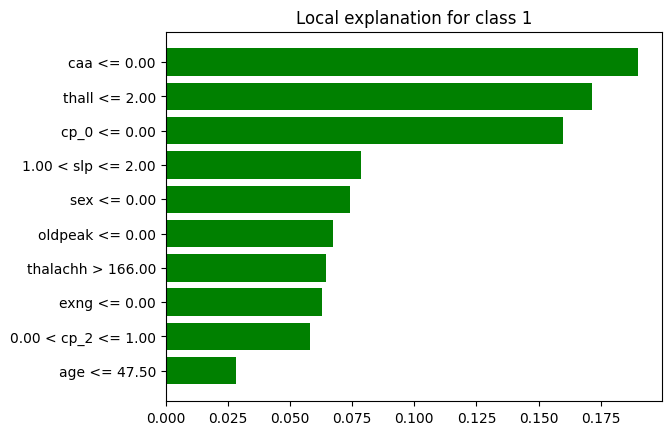

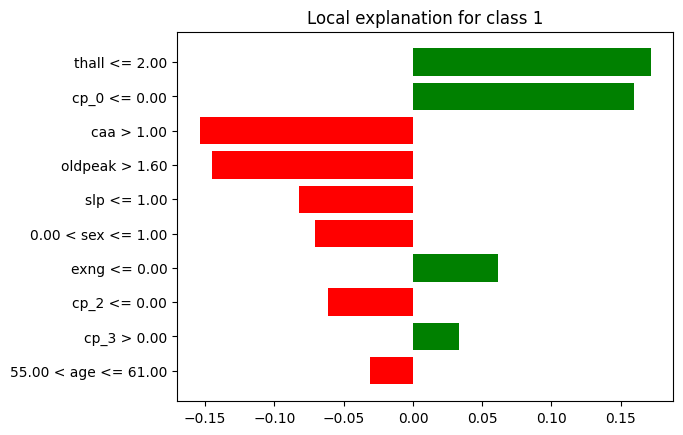

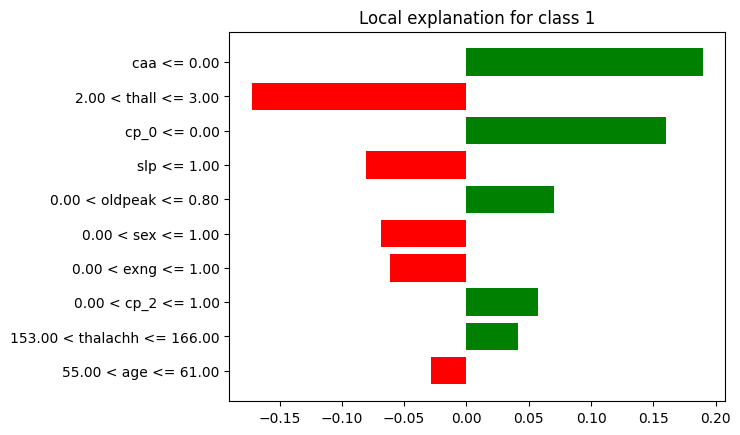

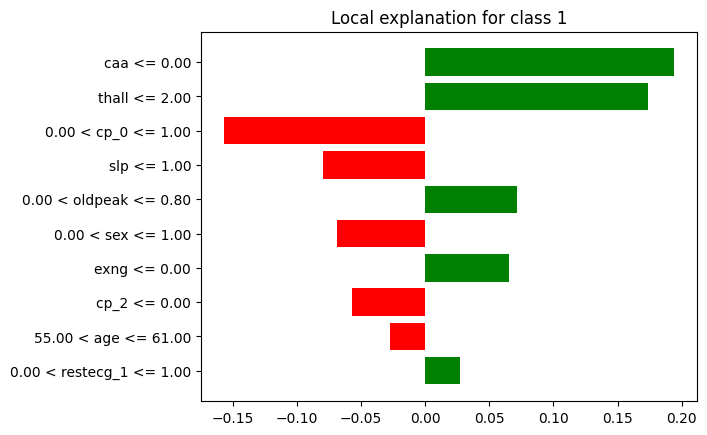

In [26]:
for explanation in lime_attributions:
    explanation.plot()

### 4. Explain using SHAP and compare with LIME

In [30]:
pf = lambda m, d: m.predict_proba(d)[:, 1]

explainer = dx.Explainer(model, X, y, predict_function=pf)

shap_attributions = [explainer.predict_parts(X.iloc[[i]], type="shap", label=f'patient {i}', random_state=SEED) for i in range(N)]

Preparation of a new explainer is initiated

  -> data              : 303 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function <lambda> at 0x7f23de206160> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.544, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.33, mean = 0.000297, max = 0.4
  -> model_info        : package sklearn

A new explainer has been created!


/home/maciej/Documents/Studia/Zima 2022/XAI/TrustworthyMachineLearning-2023/Homeworks/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but RandomForestClassifier was fitted with feature names



In [29]:
shap_attributions[0].plot(shap_attributions[1:])

### 5. Train a different model and evaluate LIME predictions

Preparation of a new explainer is initiated

  -> data              : 303 rows 18 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 303 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x7f23ebc5da60> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00166, mean = 0.545, max = 0.997
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.961, mean = -2.34e-06, max = 0.955
  -> model_info        : package sklearn

A new explainer has been created!


/home/maciej/Documents/Studia/Zima 2022/XAI/TrustworthyMachineLearning-2023/Homeworks/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



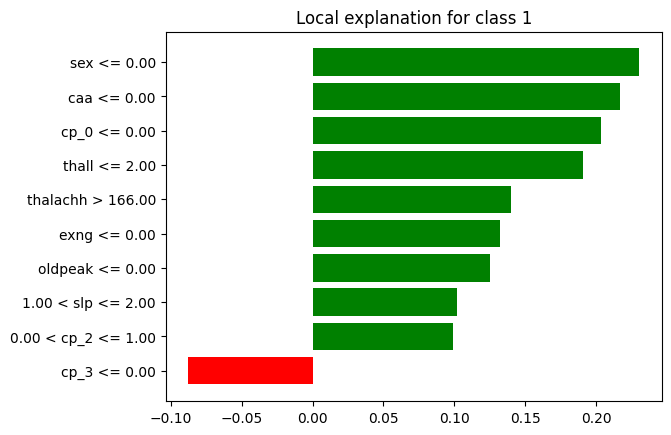

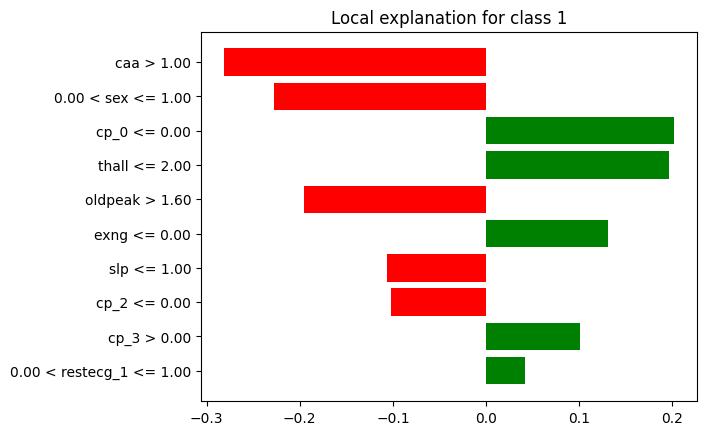

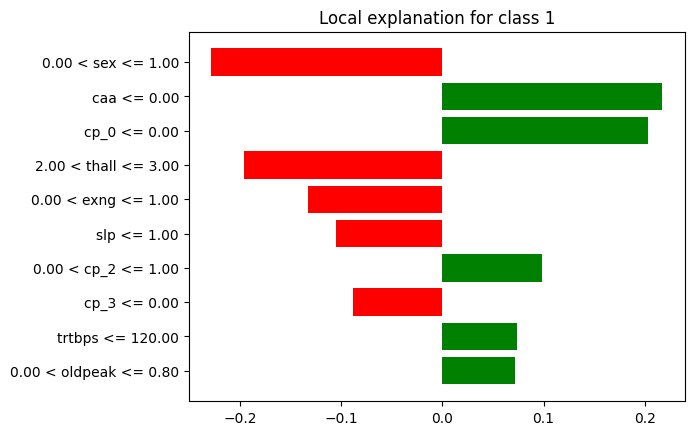

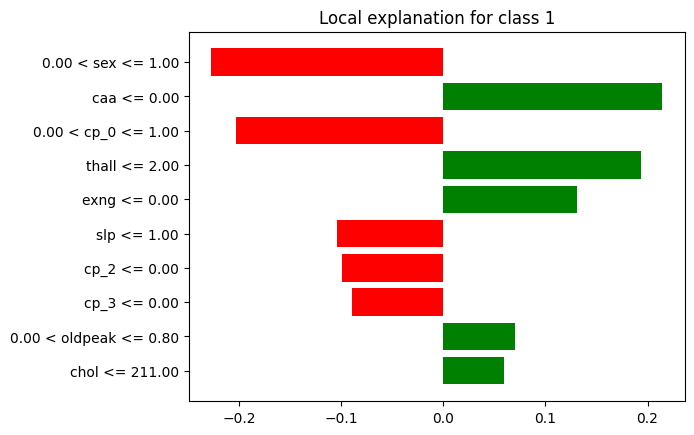

In [41]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=SEED, max_iter=5000)

model = model.fit(X, y)

explainer = dx.Explainer(model, X, y)

lime_attributions = [explainer.predict_surrogate(X.iloc[[i]], type='lime', label=f'patient {i}', random_state=SEED) for i in range(N)]
for explanation in lime_attributions:
    explanation.plot()